<a href="https://colab.research.google.com/github/TimofeiMenshikov/figures_classificator/blob/main/figures_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import random
import csv
from PIL import Image, ImageDraw



In [4]:
import os
import shutil

# Список папок для удаления
folders_to_remove = [
    'dataset/circle',
    'dataset/triangle',
    'dataset/rectangle'
]

for folder_path in folders_to_remove:
    try:
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
            print(f"Папка {folder_path} успешно удалена")
        else:
            print(f"Папка {folder_path} не существует")
    except Exception as e:
        print(f"Ошибка при удалении {folder_path}: {str(e)}")

Папка dataset/circle не существует
Папка dataset/triangle не существует
Папка dataset/rectangle не существует


In [ ]:



# Нужно нарисовать закрашенные и незакрашенные фигуры, повернутые на рандомный угол


os.makedirs("dataset", exist_ok=True)
os.makedirs("dataset/rectangle", exist_ok=True)
os.makedirs("dataset/circle", exist_ok=True)
os.makedirs("dataset/triangle", exist_ok=True)


def generate_random_shape(width=128, height=128):
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    # Случайные параметры
    shape = random.choice(["circle", "rectangle", "triangle"])
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    size = random.randint(70, 100)
    x0 = random.randint(10, width - size - 10)
    y0 = random.randint(10, height - size - 10)

    #is_filled = random.randint(0, 1)
    is_filled = 1


    if (is_filled): fill = color
    else:           fill = "white"



    # Рисование
    if shape == "circle":
        draw.ellipse((x0, y0, x0 + size, y0 + size), fill = fill, outline = color)
    elif shape == "rectangle":
        draw.rectangle((x0, y0, x0 + size, y0 + size), fill= fill, outline = color)
    elif shape == "triangle":
        points = [
            (x0 + size//2, y0),
            (x0, y0 + size),
            (x0 + size, y0 + size)
        ]
        draw.polygon(points, fill = fill, outline = color)


    #image = image.rotate(random.randint(0, 360), expand=True, fillcolor="white")

    '''ImageDraw.floodfill(
        image=image,
        xy=(0, 0),     # Стартовая точка
        value=(255, 255, 255),      # Новый цвет
        thresh=10        # Порог чувствительности (0-255)
    )'''

    return image, shape

# Пример

img = generate_random_shape()

how_many_figures = {"circle" : 0, "rectangle" : 0, "triangle" : 0}


with open("metadata.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "shape"])

    for i in range(100):
        img, shape = generate_random_shape()

        how_many_figures[shape] += 1

        filename = f"shape_{i}.png"
        img.save(f"dataset/{shape}/{filename}")
        writer.writerow([filename, shape])


img.save("random_shape.png")
print(how_many_figures)

{'circle': 34, 'rectangle': 37, 'triangle': 29}


In [ ]:
from torchvision import datasets, transforms
import torch
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
from torch.utils.data import random_split


# Определите трансформации
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Изменение размера
    transforms.ToTensor(),           # Конвертация в тензор
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # Средние для ImageNet
        std=[0.229, 0.224, 0.225]       # Стандартные отклонения
    )

])

# Создайте Dataset
dataset = datasets.ImageFolder(
    root='dataset',  # Путь к корневой папке с классами
    transform=transform
)



# Пример просмотра информации о датасете
print(f"Classes: {dataset.classes}")
print(f"Total samples: {len(dataset)}")
print(f"Sample tensor shape: {dataset[0][0].shape}")

n_train = int(len(dataset) * 0.64)
n_valid = int(len(dataset) * 0.16)
n_test  = len(dataset) - n_train - n_valid



train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train, n_valid, n_test],
    generator=torch.Generator().manual_seed(42)  # Для воспроизводимости
)

Classes: ['circle', 'rectangle', 'triangle']
Total samples: 100
Sample tensor shape: torch.Size([3, 64, 64])


In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=10,  # Обрабатывать по 10 образцов за шаг
    shuffle = True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = 10,
    shuffle = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 10,
    shuffle = True
)

In [ ]:
import torch.nn as nn

In [ ]:
# Параметры модели
input_size = (3, 64, 64)  # [каналы, высота, ширина]
num_classes = 3           # круг, квадрат, треугольник

class LinearImageClassifier(nn.Module):
    def __init__(self, input_size=64*64*3, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            # Полносвязные слои
            nn.Linear(input_size, 512),  # 64*64*3 = 12288 входных нейронов → 512
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)  # Преобразует [batch, 3, 64, 64] → [batch, 3*64*64]
        x = self.layers(x)
        return x

model = LinearImageClassifier(input_size=3*64*64, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Пример: model = ShapeClassifier().to(device)
print(f"Используется устройство: {device}")



Используется устройство: cpu


In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()  # Для классификации
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Или SGD

In [ ]:
def test(dataloader):

    correct = 0
    total = 0



    with torch.no_grad():
        for inputs, labels in dataloader:


            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            #print(outputs.data)
            _, predicted = torch.max(outputs.data, 1)


            #print("predicted:", predicted, "output:", labels)

            for i in range(len(predicted)):
                correct += (predicted[i] == labels[i])
                total   += 1

    return float(100 * correct / total)

In [ ]:
train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

In [ ]:
num_epochs = 10

print(len(train_dataloader))

print(len(valid_dataloader))



for epoch in range(num_epochs):

    # Обучение
    model.train()

    train_loss = 0.0

    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_acc = test(train_dataloader)
    print(f"Train Loss: {train_loss/len(train_dataloader):.4f}", "Train accuracy: ", train_acc)
    train_losses.append(train_loss/len(train_dataloader))
    train_accs.append(train_acc)


    # Валидация
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_batch in valid_dataloader:
            inputs, labels = val_batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_fn(outputs, labels).item()

        valid_acc = test(valid_dataloader)

        print(f"Val Loss: {val_loss/len(valid_dataloader):.4f}", "Valid accuracy: ", valid_acc)
        valid_losses.append(val_loss/len(valid_dataloader))
        valid_accs.append(valid_acc)

# Сохранение
torch.save(model.state_dict(), "model.pth")

7
2
Train Loss: 0.2140 Train accuracy:  90.625
Val Loss: 0.2820 Valid accuracy:  87.5
Train Loss: 0.2539 Train accuracy:  92.1875
Val Loss: 0.4380 Valid accuracy:  75.0
Train Loss: 0.2571 Train accuracy:  92.1875
Val Loss: 0.3626 Valid accuracy:  87.5
Train Loss: 0.1371 Train accuracy:  93.75
Val Loss: 0.3651 Valid accuracy:  75.0
Train Loss: 0.1976 Train accuracy:  90.625
Val Loss: 0.3673 Valid accuracy:  81.25
Train Loss: 0.1592 Train accuracy:  98.4375
Val Loss: 0.5022 Valid accuracy:  87.5
Train Loss: 0.1264 Train accuracy:  96.875
Val Loss: 0.5347 Valid accuracy:  75.0
Train Loss: 0.1765 Train accuracy:  96.875
Val Loss: 0.3104 Valid accuracy:  81.25
Train Loss: 0.1906 Train accuracy:  96.875
Val Loss: 0.3205 Valid accuracy:  75.0
Train Loss: 0.1569 Train accuracy:  95.3125
Val Loss: 0.2498 Valid accuracy:  87.5


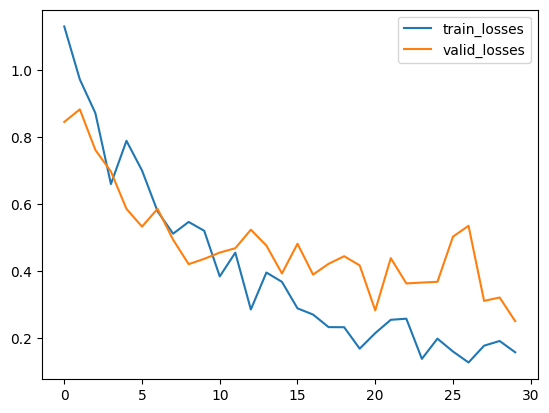

In [ ]:

plt.plot(train_losses, label = "train_losses")
plt.plot(valid_losses, label = "valid_losses")

plt.legend()
plt.show()



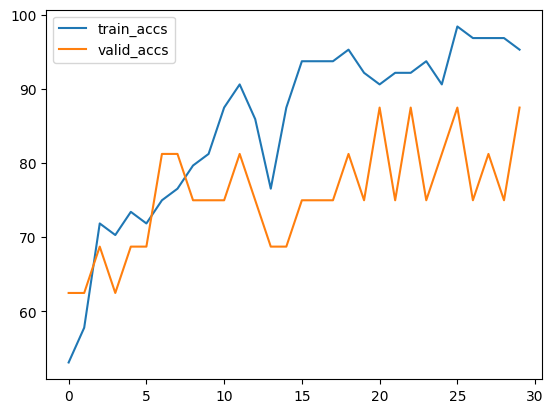

In [ ]:
plt.plot(train_accs, label = "train_accs")
plt.plot(valid_accs, label = "valid_accs")

plt.legend()
plt.show()


In [ ]:
print(test(test_dataloader))
print(test(train_dataloader))
print(test(valid_dataloader))

90.0
100.0
87.5
